<a target="_blank" href="https://colab.research.google.com/github/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including [LlamaIndex](https://www.llamaindex.ai/) and [LangChain](https://www.langchain.com/), however, the goal of building from scratch is to be able to inspect and customize all the parts.

 ## What we're going to build

We're going to build RAG pipeline which enables us to chat with a PDF document, specifically an open-source [nutrition textbook](https://pressbooks.oer.hawaii.edu/humannutrition2/), ~1200 pages long.

You could call our project NutriChat!

We'll write the code to:
1. Open a PDF document (you could use almost any PDF here).
2. Format the text of the PDF textbook ready for an embedding model (this process is known as text splitting/chunking).
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.

The above steps can broken down into two major sections:
1. Document preprocessing/embedding creation (steps 1-3).
2. Search and answer (steps 4-6).

And that's the structure we'll follow.

It's similar to the workflow outlined on the NVIDIA blog which [details a local RAG pipeline](https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/).

<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.2 MB/s et

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [ ]:
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 264,
  'page_char_count': 1864,
  'page_word_count': 313,
  'page_sentence_count_raw': 12,
  'page_token_count': 466.0,
  'text': '• Focus on calories in certain food categories such as beverages  and confections, and encourage consumption of positive  nutrients and foods such as cereals and low-fat or fat-free  dairy products.  The Most Notorious Sugar  Before high-fructose corn syrup (HFCS) was marketed as the best  food and beverage sweetener, sucrose (table sugar) was the  number-one sweetener in America. (Recall that sucrose, or table  sugar, is a disaccharide consisting of one glucose unit and one  fructose unit.) HFCS also contains the simple sugars fructose and  glucose, but with fructose at a slightly higher concentration. In  the production of HFCS, corn starch is broken down to glucose,  and some of the glucose is then converted to fructose. Fructose  is sweeter than glucose; hence many food manufacturers choose  to sweeten foods with HFCS. HFCS is used as a

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

In [ ]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 412,
  'page_char_count': 1551,
  'page_word_count': 255,
  'page_sentence_count_raw': 15,
  'page_token_count': 387.75,
  'text': 'Simply put, different protein sources differ in their additional  components, so it is necessary to pay attention to the whole  nutrient “package.” Protein-rich animal-based foods commonly  have high amounts of B vitamins, vitamin E, iron, magnesium, and  zinc. Seafood often contains healthy fats, and plant sources of  protein contain a high amount of fiber. Some animal-based protein- rich foods have an unhealthy amount of saturated fat and  cholesterol. When choosing your dietary sources of protein, take  note of the other nutrients and also the non-nutrients, such as  cholesterol, dyes, and preservatives, in order to make good  selections that will benefit your health. For instance, a hamburger  patty made from 80 percent lean meat contains 22 grams of protein,  5.7 grams of saturated fat, and 77 milligrams of cholesterol. A burger  made

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we gorup those sentences?

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 1089,
  'page_char_count': 1228,
  'page_word_count': 202,
  'page_sentence_count_raw': 13,
  'page_token_count': 307.0,
  'text': 'with osteoporosis may not know he has the disease until he  experiences a bone break or fracture. Detection and treatment of  osteoporosis, before the occurrence of a fracture, can significantly  improve the quality of life. To detect osteopenia or osteoporosis,  BMD must be measured by the DEXA procedure.  During the course of osteoporosis, BMD decreases and the bone  tissue  microarchitecture  is  compromised.  Excessive  bone  resorption in the trabecular tissue increases the size of the holes  in the lattice-like structure making it more porous and weaker. A  disproportionate amount of resorption of the strong cortical bone  causes it to become thinner. The deterioration of one or both types  of bone tissue causes bones to weaken and, consequently, become  more susceptible to fractures. The American Academy of  Orthopaedic Surgeons rep

In [ ]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 212,
  'sentence_chunk': 'Accessed March 17, 2011. 212 | Water Concerns',
  'chunk_char_count': 45,
  'chunk_word_count': 8,
  'chunk_token_count': 11.25}]

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [ ]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 3.25 | Text: 814 | Infancy
Chunk token count: 11.25 | Text: Carbohydrates and Personal Diet Choices | 275
Chunk token count: 25.25 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=306 484 | Weight Management
Chunk token count: 28.5 | Text: The World Bank claims that a million deaths occur every year from anemia and that the majority of those Iron | 663
Chunk token count: 24.75 | Text: Free radical reactions can continue unchecked unless stopped by a defense mechanism. The Atom | 461


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

Smaller chunks filtered!

Time to embed our chunks of text!

In [ ]:
!pip uninstall -y transformers sentence-transformers
!pip install transformers==4.39.3 sentence-transformers==2.6.1


Found existing installation: transformers 4.54.0
Uninstalling transformers-4.54.0:
  Successfully uninstalled transformers-4.54.0
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/prepare.py", line 16, in <module>
    from pip._internal.distributions import make_distribution_for_install_requirement
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/distributions/__init__.py", line 2, in <module>
    from p

In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu") # Set device to "cpu"

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

Woah! That's a lot of numbers.

How about we do just once sentence?

In [ ]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077055e-03 -4.98486962e-03  6.55444860e-02
 -9.87674389e-03  2.72836108e-02  3.66426110e-02 -3.30219767e-03
  8.50078650e-03  8.24952498e-03 -2.28497703e-02  4.02430147e-02
 -5.75200692e-02  6.33691847e-02  4.43207137e-02 -4.49506715e-02
  1.25284614e-02 -2.52011847e-02 -3.55293006e-02  1.29559003e-02
  8.67021922e-03 -1.92917790e-02  3.55635840e-03  1.89505480e-02
 -1.47128161e-02 -9.39848833e-03  7.64175924e-03  9.62184742e-03
 -5.98920882e-03 -3.90168726e-02 -5.47824651e-02 -5.67456335e-03
  1.11644426e-02  4.08067517e-02  1.76319088e-06  9.15305596e-03
 -8.77257995e-03  2.39382870e-02 -2.32784245e-02  8.04999843e-02
  3.19176875e-02  5.12598455e-03 -1.47708450e-02 -1.62525177e-02
 -6.03213124e-02 -4.35689688e-02  4.51211594e-02 -1.79053694e-02
  2.63366792e-02 -3.47866528e-02 -8.89172778e-03 -5.47675341e-02
 -1.24372439e-02 -2.38606706e-02  8.33496898e-02  5.71241677e-02
  1.13328267e-02 -1.49595067e-02  9.2037

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.

How about we add an embedding field to each of our chunk items?

Let's start by trying to create embeddings on the CPU, we'll time it with the `%%time` magic to see how long it takes.

In [ ]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs


In [ ]:
%%time

# Send the model to the GPU # REMOVED: .to("cuda")
# embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 19min 4s, sys: 2.47 s, total: 19min 7s
Wall time: 19min 12s


Woah! Looks like the embeddings get created much faster (~10x faster on my machine) on the GPU!

You'll likely notice this trend with many of your deep learning workflows. If you have access to a GPU, especially a NVIDIA GPU, you should use one if you can.

But what if I told you we could go faster again?

You see many modern models can handle batched predictions.

This means computing on multiple samples at once.

Those are the types of operations where a GPU flourishes!

We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

KeyboardInterrupt: 

That's what I'm talking about!

A ~4x improvement (on my GPU) in speed thanks to batched operations.

So the tip here is to use a GPU when you can and use batched operations if you can too.

Now let's save our chunks and their embeddings so we could import them later if we wanted.

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02279988e-02 -5.09551819e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156493e-02 5.92137985e-02 -1.66167784e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801469e-02 3.39813307e-02 -2.06427258e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566613e-02 3.81274484e-02 -8.46858509e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264196e-02 -8.49771872e-03 9.57152341e-...


### Chunking and embedding questions

> **Which embedding model should I use?**

This depends on many factors. My best advice is to experiment, experiment, experiment!

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware.

A good place to see how different models perform on a wide range of embedding tasks is the [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

> **What other forms of text chunking/splitting are there?**

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, [Pinecone has a great guide on different kinds of chunking](https://www.pinecone.io/learn/chunking-strategies/) including for different kinds of data such as markdown and LaTeX.

Libraries such as [LangChain also have a good amount of in-built text splitting options](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

> **What should I think about when creating my embeddings?**

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

> **Where should I store my embeddings?**

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.



## 2. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How?

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with:
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
>
> as the first result. How cool!

If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [ ]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242601, 0.0902279988, -0.00509551819, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156493, 0.0592137985, -0.0166167784, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801469, 0.0339813307, -0.0206427258, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566613, 0.0381274484, -0.00846858509, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264196, -0.00849771872, 0.00957152341, ..."


In [ ]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1677e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1828e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8009e-02,  2.2295e-02,  5.6136e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6370e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4898e-04, -9.9662e-02,  4.9

Nice!

Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above.

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:
1. Define a query string (e.g. `"macronutrients functions"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

Easy!


In [ ]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "nutrients"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: nutrients
Time take to get scores on 1680 embeddings: 0.00093 seconds.


torch.return_types.topk(
values=tensor([0.6809, 0.6628, 0.6430, 0.6119, 0.6086]),
indices=tensor([  41,   47, 1042,  148,   52]))

Woah!! Now that was fast!

~0.00008 seconds to perform a dot product comparison across 1680 embeddings on my machine (NVIDIA RTX 4090 GPU).

GPUs are optimized for these kinds of operations.

So even if you we're to increase our embeddings by 100x (1680 -> 168,000), an exhaustive dot product operation would happen in ~0.008 seconds (assuming linear scaling).

Heck, let's try it.

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.06501 seconds.


Wow. That's quick!

That means we can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).

Let's check the results of our original similarity search.

[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'nutrients'

Results:
Score: 0.6809
Text:
Learning Objectives By the end of this chapter, you will be able to: • Describe
basic concepts in nutrition • Describe factors that affect your nutritional
needs • Describe the importance of research and scientific methods to
understanding nutrition What are Nutrients? The foods we eat contain nutrients.
Nutrients are substances required by the body to perform its basic functions.
Nutrients must be obtained from our diet, since the human body does not
synthesize or produce them. Nutrients have one or more of three basic functions:
they provide energy, contribute to body structure, and/or regulate chemical
processes in the body. These basic functions allow us to detect and respond to
environmental surroundings, move, excrete wastes, respire (breathe), grow, and
reproduce. There are six classes of nutrients required for the body to function
and maintain overall health. These are carbohydrates, lipids, proteins, water,
vitamins, and mineral

The first result looks to have nailed it!

We get a very relevant answer to our query `"macronutrients functions"` even though its quite vague.

That's the power of semantic search!

And even better, if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

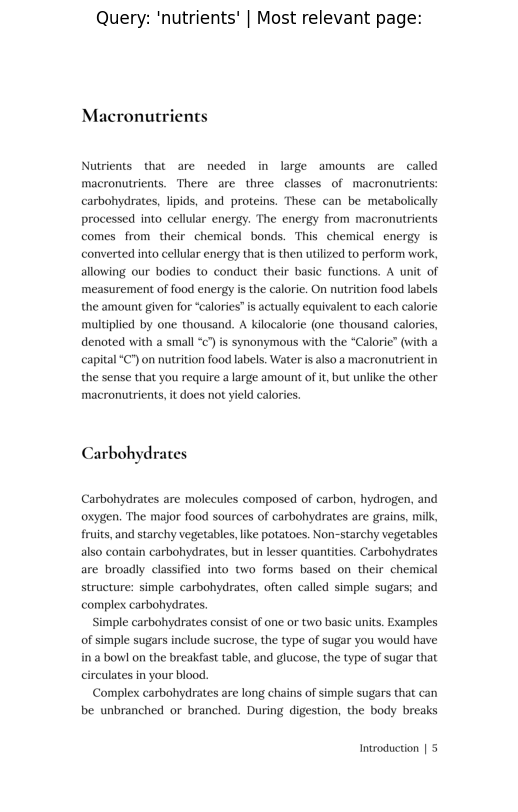

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

Nice!

Now we can do extra research if we'd like.

We could repeat this workflow for any kind of query we'd like on our textbook.

And it would also work for other datatypes too.

We could use semantic search on customer support documents.

Or email threads.

Or company plans.

Or our old journal entries.

Almost anything!

The workflow is the same:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

And we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

Before we get to the next two steps, let's take a small aside and discuss similarity measures.

### Similarity measures: dot product and cosine similarity

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude.

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity).

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them.

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [ ]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00093 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721]),
 tensor([ 822,  853, 1536, 1555, 1531]))

In [ ]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00072 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th